In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import random
import numpy as np
import cv2
import imageio
from scipy.ndimage import zoom
from skimage import io
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, Activation, BatchNormalization, Add, multiply,GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from google.colab import drive
from sklearn.metrics import mean_squared_error
#################################################################
drive.mount('/content/drive')
# seed = 42
# np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

'''
Useful blocks to build Unet

conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

'''

input_folder1 = '/content/drive/MyDrive/CNN data/Redo_28GHz/High/Mixed_Permittivity_channel/'
input_folder2 = '/content/drive/MyDrive/CNN data/Redo_28GHz/High/Mixed_Conductivity_channel/'
input_folder3 = '/content/drive/MyDrive/CNN data/Redo_28GHz/High/FSPL/'
output_folder = '/content/drive/MyDrive/CNN data/Redo_28GHz/High/Heatmap_mixed/'

# Lists to store resized images
input_images1 = []
input_images2 = []
input_images3 = []
input_tensors = []
output_images = []

# Assuming filenames in both folders are aligned
for filename in sorted(os.listdir(input_folder1)):
    if filename.endswith(".jpg") :  # adjust as needed
        # Read and resize input image
        input_img_path = os.path.join(input_folder1, filename)
        input_img1 = Image.open(input_img_path).resize((IMG_WIDTH,IMG_HEIGHT))
        # input_img1 = input_img1.convert('L')
        input_images1.append(np.array(input_img1))

for filename in sorted(os.listdir(input_folder2)):
    if filename.endswith(".jpg") :  # adjust as needed
        # Read and resize input image
        input_img_path = os.path.join(input_folder2, filename)
        input_img2 = Image.open(input_img_path).resize((IMG_WIDTH,IMG_HEIGHT))
        # input_img2 = input_img2.convert('L')
        input_images2.append(np.array(input_img2))

for filename in sorted(os.listdir(input_folder3)):
    if filename.endswith(".jpg") :  # adjust as needed
        # Read and resize input image
        input_img_path = os.path.join(input_folder3, filename)
        input_img3 = Image.open(input_img_path).resize((IMG_WIDTH,IMG_HEIGHT))
        input_img3 = input_img3.convert('L')
        input_images3.append(np.array(input_img3))

for i in range(0, 2997, 999):
    for j in range(999):
        # Stacking images from input_folder1, input_folder2, and the corresponding image from folder3
        combined = np.stack((input_images1[i+j], input_images2[i+j], input_images3[i//999]), axis=-1)
        input_tensors.append(combined)

X_allset = np.array(input_tensors)

for filename in sorted(os.listdir(output_folder)):
    if filename.endswith(".jpg") :  # adjust as needed
        # Read and resize corresponding output image
        output_img_path = os.path.join(output_folder, filename)  # assuming the naming is consistent
        output_img = Image.open(output_img_path).resize((IMG_WIDTH//2,IMG_HEIGHT//2))
        # output_img = Image.open(output_img_path).resize((IMG_WIDTH,IMG_HEIGHT))
        output_images.append(np.array(output_img))

# Convert lists to numpy arrays
Y_allset = np.array(output_images)
# Generate shuffled indices
indices = np.arange(X_allset.shape[0])
# np.random.shuffle(indices)

X_allset_shuffled = X_allset[indices]
Y_allset_shuffled = Y_allset[indices]
TrainingSize = 2900
X_train = X_allset_shuffled[:TrainingSize]
Y_train = Y_allset_shuffled[:TrainingSize]

X_test = X_allset_shuffled[TrainingSize:]
Y_test = Y_allset_shuffled[TrainingSize:]

print(indices[2996])

Mounted at /content/drive
2996


In [ ]:
########################################################################################
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def res_conv_block(x, filter_size, size, dropout, batch_norm=False,reg=l2(0.001)):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same', kernel_regularizer=reg)(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same', kernel_regularizer=reg)(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same', kernel_regularizer=reg)(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)
# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                #  strides=(1,1),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

# Specify the L2 regularization factor
l2_reg = 0.01

def Attention_EfficientUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True,reg=l2(l2_reg)):
    '''
    Efficient UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    efficientnetb5 = tf.keras.applications.EfficientNetB5(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in efficientnetb5.layers:
        layer.trainable = True

    # You need to find out the equivalent layers in EfficientNet B7
    # For example, let's assume you've identified the layers in EfficientNet B7 that you want to use
    conv_128 = efficientnetb5.get_layer('block2a_expand_activation').output  # Example layer
    conv_64 = efficientnetb5.get_layer('block3a_expand_activation').output   # Example layer
    conv_32 = efficientnetb5.get_layer('block4a_expand_activation').output   # Example layer
    conv_16 = efficientnetb5.get_layer('block5a_expand_activation').output   # Example layer

    # Bridge
    bridge = efficientnetb5.get_layer('top_activation').output
    # print("conv_128:", K.int_shape(conv_128))
    # print("conv_64:", K.int_shape(conv_64))
    # print("conv_32:", K.int_shape(conv_32))
    # print("conv_16:", K.int_shape(conv_16))
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(bridge, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(bridge)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm, reg=reg)
    # print("gating_16:", K.int_shape(gating_16))
    # print("att_16:", K.int_shape(att_16))
    # print("up_16:", K.int_shape(up_16))
    # print("up_conv_16:", K.int_shape(up_conv_16))

    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm, reg=reg)
    # print("gating_32:", K.int_shape(gating_32))
    # print("att_32:", K.int_shape(att_32))
    # print("up_32:", K.int_shape(up_32))
    # print("up_conv_32:", K.int_shape(up_conv_32))

    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm, reg=reg)
    # print("gating_64:", K.int_shape(gating_64))
    # print("att_64:", K.int_shape(att_64))
    # print("up_64:", K.int_shape(up_64))
    # print("up_conv_64:", K.int_shape(up_conv_64))

    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm, reg=reg)
    # print("gating_128:", K.int_shape(gating_128))
    # print("att_128:", K.int_shape(att_128))
    # print("up_128:", K.int_shape(up_128))
    # print("up_conv_128:", K.int_shape(up_conv_128))

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1), kernel_regularizer=reg)(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('linear')(conv_final)  #Change to softmax for multichannel
    # print("conv_final:", K.int_shape(conv_final))

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

# Create the model
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
model = Attention_EfficientUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.5, batch_norm=True)
# model.summary()
# learning_rate_start = 1e0
# learning_rate_end =   1e-8
learning_rate_start = 1e-2
learning_rate_end =   1e-4
decay_steps = 1500
# Define the polynomial decay
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=learning_rate_start,
    decay_steps=decay_steps,
    end_learning_rate=learning_rate_end,
    power=1.0  # This makes it a linear decay
)

# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule), loss='mean_squared_error', metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9), loss='mean_squared_error', metrics=['accuracy'])
# Check the size of the training datas
print(X_train.shape)
print(Y_train.shape)
print("Input shape:", model.output_shape)
# model.summary()


115263384/115263384 [==============================] - 3s 0us/step
(2900, 256, 256, 3)
(2900, 128, 128)
Input shape: (None, 128, 128, 1)


In [ ]:

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_floorplan.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

# results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=20, epochs=200, callbacks=callbacks)

# Fit the model and save the history
history = model.fit(X_train, Y_train, validation_split=0.3, batch_size=32, epochs=30, callbacks=callbacks)
# model.save('/content/drive/MyDrive/CNN data/Redo_28GHz/High/Model_AttnUnet_28GHz_1st_leg.keras')
# Training Error: Mean Squared Error
training_error = history.history['loss']

# Validation Error: Mean Squared Error on the validation set
validation_error = history.history['val_loss']

# Calculate the number of epochs actually run
epochs_run = range(len(training_error))

# Set a threshold for the training and validation error in order to plot a sensible figure
threshold = 1800
training_error = [min(error, threshold) for error in training_error]
validation_error = [min(error, threshold) for error in validation_error]

# Plot training & validation errors
plt.figure(figsize=(10, 5))
plt.plot(epochs_run, training_error, 'g-', label='Training error')
plt.plot(epochs_run, validation_error, 'r-', label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()
print('Training error:',training_error[-1])
print('Validation error:',validation_error[-1])


Epoch 1/30
64/64 [==============================] - 148s 792ms/step - loss: 1492.9249 - accuracy: 3.0081e-08 - val_loss: 1150.9437 - val_accuracy: 0.0000e+00
Epoch 2/30
64/64 [==============================] - 27s 428ms/step - loss: 79.2900 - accuracy: 3.0081e-08 - val_loss: 99.3511 - val_accuracy: 0.0000e+00
Epoch 3/30
64/64 [==============================] - 27s 428ms/step - loss: 67.4488 - accuracy: 3.0081e-08 - val_loss: 98.3631 - val_accuracy: 0.0000e+00
Epoch 4/30
64/64 [==============================] - 27s 429ms/step - loss: 55.8988 - accuracy: 3.0081e-08 - val_loss: 85.9199 - val_accuracy: 0.0000e+00
Epoch 5/30
12/64 [====>.........................] - ETA: 20s - loss: 50.5935 - accuracy: 1.5895e-07

KeyboardInterrupt: 

In [ ]:
#####################################################
# In terms of the 1st leg
# Plot the training sample
#####################################################
# model = tf.keras.models.load_model('/content/drive/MyDrive/CNN data/Redo_28GHz/High/Model_AttnUnet_28GHz_1st_leg.keras', safe_mode=False)
i=0
# Extract the first sample
first_sample = X_train[i]
# Expand dimensions to simulate a batch of size 1
first_sample = np.expand_dims(first_sample, axis=0)  # first_sample.shape = (1, 256, 256, 3)
# Predict
prediction = model.predict(first_sample)
# Resize the coverage map to its original size
prediction_resized = zoom(prediction.squeeze(), (65/prediction.shape[1], 115/prediction.shape[2]))
Y_train_resized = zoom(Y_train[i].squeeze(), (65/Y_train[i].shape[0], 115/Y_train[i].shape[1]))

# Define the color map
cmap = plt.cm.jet

# Determine the range of your data for consistent color mapping
combined = np.concatenate((prediction_resized.flatten(), Y_train_resized.flatten()))
min_val = combined.min()
max_val = combined.max()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the prediction heatmap
cax1 = axes[0].imshow(prediction_resized, interpolation='nearest', cmap=cmap, vmin=min_val, vmax=max_val)
axes[0].set_title("Prediction")
axes[0].axis('off')

# Display the ground truth heatmap
cax2 = axes[1].imshow(Y_train_resized, interpolation='nearest', cmap=cmap, vmin=min_val, vmax=max_val)
axes[1].set_title('RT Simulation')
axes[1].axis('off')

# Add colorbar, make sure to specify the ticks you want to display
# and their corresponding labels
colorbar = fig.colorbar(cax2, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.046, pad=0.04)
colorbar.set_label('Signal Strength (dBm)')
colorbar.set_ticks([min_val, max_val])
colorbar.set_ticklabels(['-125.5 dBm', '-54.6 dBm'])

plt.show()

# Numberical results including RMSE and CDF plot
squared_differences_train = (prediction.squeeze()- Y_train[i])**2
rmse_train = np.sqrt(squared_differences_train.mean())

difference = np.abs(prediction.squeeze()- Y_train[i])
flattened_diff = difference.flatten()

# Calculate the CDF
hist, bin_edges = np.histogram(flattened_diff, bins=256, range=(0, 256), density=True)
cdf = np.cumsum(hist) * np.diff(bin_edges)
# Plot the CDF
plt.plot(cdf, color='blue')
plt.title('CDF of Image Difference')
plt.xlabel('Pixel Intensity Difference')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()
print("RMSE of Training Sample:", rmse_train)

import scipy.io as sio
from google.colab import files
sio.savemat('prediction_resized.mat', {'prediction_resized': prediction_resized})
files.download('prediction_resized.mat')

4/4 [==============================] - 5s 60ms/step
Overall Testing Error (RMSE): 3.807223
1/1 [==============================] - 0s 45ms/step


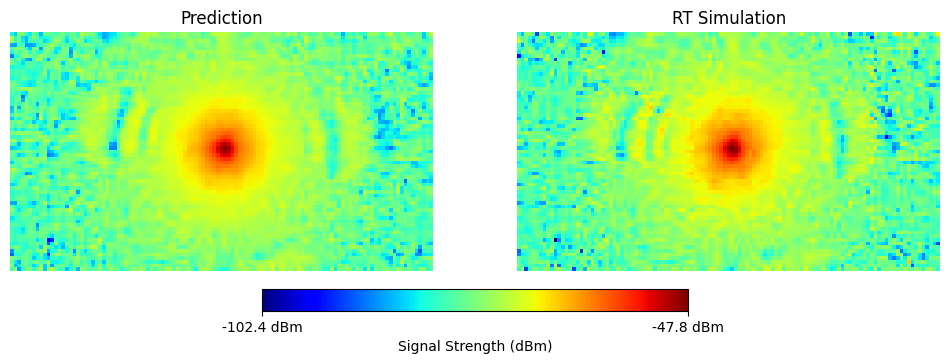

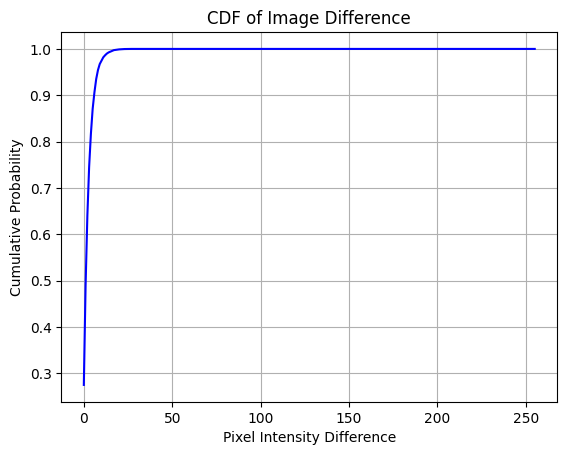

RMSE of Testing Sample: 4.1974053


In [ ]:
#####################################################
# In terms of the 1st leg
# Plot the testing sample
#####################################################

# model = tf.keras.models.load_model('/content/drive/MyDrive/CNN data/Redo_28GHz/High/Model_AttentionUnet_Furniture_Mixed.keras')
# Calculating Overall Testing Error
# First, obtain predictions for the testing set
predictions = model.predict(X_test)
# Ensure that predictions and Y_test are reshaped or flattened if they are multi-dimensional, to compute RMSE correctly
predictions = predictions.flatten()
actuals = Y_test.flatten()
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actuals, predictions)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Overall Testing Error (RMSE):", rmse)

i=0
first_sample = X_test[i]
first_sample = np.expand_dims(first_sample, axis=0)  # first_sample.shape = (1, 256, 256, 3)
prediction = model.predict(first_sample)
prediction_resized = zoom(prediction.squeeze(), (65/prediction.shape[1], 115/prediction.shape[2]))
Y_test_resized = zoom(Y_test[i].squeeze(), (65/Y_test[i].shape[0], 115/Y_test[i].shape[1]))
# Define the color map
cmap = plt.cm.jet

# Determine the range of your data for consistent color mapping
combined = np.concatenate((prediction_resized.flatten(), Y_test_resized.flatten()))
min_val = combined.min()
max_val = combined.max()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the prediction heatmap
cax1 = axes[0].imshow(prediction_resized, interpolation='nearest', cmap=cmap, vmin=min_val, vmax=max_val)
axes[0].set_title("Prediction")
axes[0].axis('off')

# Display the ground truth heatmap
cax2 = axes[1].imshow(Y_test_resized, interpolation='nearest', cmap=cmap, vmin=min_val, vmax=max_val)
axes[1].set_title('RT Simulation')
axes[1].axis('off')

# Add colorbar, make sure to specify the ticks you want to display
# and their corresponding labels
colorbar = fig.colorbar(cax2, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.046, pad=0.04)
colorbar.set_label('Signal Strength (dBm)')
colorbar.set_ticks([min_val, max_val])
# colorbar.set_ticklabels(['-125.5 dBm', '-54.6 dBm'])
colorbar.set_ticklabels(['-102.4 dBm', '-47.8 dBm'])

plt.show()

# Numberical results including RMSE and CDF plot
squared_differences_test = (prediction.squeeze()- Y_test[i])**2
rmse_test = np.sqrt(squared_differences_test.mean())
difference = np.abs(prediction.squeeze()- Y_test[i])
flattened_diff = difference.flatten()

# Calculate the CDF
hist, bin_edges = np.histogram(flattened_diff, bins=256, range=(0, 256), density=True)
cdf = np.cumsum(hist) * np.diff(bin_edges)
# Plot the CDF
plt.plot(cdf, color='blue')
plt.title('CDF of Image Difference')
plt.xlabel('Pixel Intensity Difference')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()
print("RMSE of Testing Sample:", rmse_test)

In [ ]:
#####################################################
# Save the corase prediction from 1st leg to dir: .../Coarse Pred
#####################################################
# model = tf.keras.models.load_model('/content/drive/MyDrive/CNN data/Redo_28GHz/High/Model_AttnResUnet_Furniture_Mixed_2.0.keras', safe_mode=False)

# Directory where you want to save the predicted images
save_dir = '/content/drive/MyDrive/CNN data/Redo_28GHz/High/Coarse Pred/'
# Loop through all the files in the folder
# Delete the folder if it exists
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    print(f"Deleted the folder: {save_dir}")

# Create the folder
os.makedirs(save_dir)
print(f"Created a new folder: {save_dir}")

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Iterate over your images in X_Train and predict
for i, image in enumerate(X_train, start=0):
    print(f"Processing image {i+1}/{len(X_train)}...")
    # Ensure the image is normalized if your model expects that
    image = X_train[i]

    # Predict the image (add batch dimension since model expects it)
    prediction = model.predict(np.expand_dims(image, axis=0))

    # Assuming the prediction is an image
    predicted_image = prediction.squeeze()  # Remove the batch dimension
    # predicted_image = (predicted_image * 255).astype(np.uint8)  # Convert back to image format if necessary

    # Save the predicted image
    save_path = os.path.join(save_dir, f"Coarse Pred_{i}.jpg")
    cv2.imwrite(save_path, predicted_image)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 40ms/step
Processing image 402/2900...
1/1 [==============================] - 0s 41ms/step
Processing image 403/2900...
1/1 [==============================] - 0s 44ms/step
Processing image 404/2900...
1/1 [==============================] - 0s 42ms/step
Processing image 405/2900...
1/1 [==============================] - 0s 41ms/step
Processing image 406/2900...
1/1 [==============================] - 0s 40ms/step
Processing image 407/2900...
1/1 [==============================] - 0s 42ms/step
Processing image 408/2900...
1/1 [==============================] - 0s 41ms/step
Processing image 409/2900...
1/1 [==============================] - 0s 41ms/step
Processing image 410/2900...
1/1 [==============================] - 0s 41ms/step
Processing image 411/2900...
1/1 [==============================] - 0s 42ms/step
Processing image 412/2900...
1/1 [==============================] - 0s 42ms/step
Proces

In [ ]:
#####################################################
# Read the results from 1st leg, and make it as the input for the 2nd leg
#####################################################

input_folder4 = '/content/drive/MyDrive/CNN data/Redo_28GHz/High/Coarse Pred/'
input_images4 = []
input_tensors_2nd_leg = []
for filename in sorted(os.listdir(input_folder4)):
    if filename.endswith(".jpg") :  # adjust as needed
        # Read and resize input image
        input_img_path = os.path.join(input_folder4, filename)
        input_img4 = Image.open(input_img_path)
        # input_img4 = input_img4.convert('L')
        input_images4.append(np.array(input_img4))

upsampled_input_images4 = []

# Assuming input_images4 is a list of numpy arrays
for image in input_images4:
    # Convert the numpy array image back to a PIL image
    img = Image.fromarray(image)

    # Resize the image using PIL's resize method. You can change the resampling filter as needed.
    # Image.BILINEAR, Image.BICUBIC, and Image.LANCZOS are other options.
    upsampled_img = img.resize((256, 256), Image.NEAREST)

    # Convert the PIL image back to a numpy array if needed
    upsampled_input_images4.append(np.array(upsampled_img))

# If you need the result as a numpy array
upsampled_input_images4 = np.array(upsampled_input_images4)

input_1 = X_train[:,:,:,1]
input_2 = X_train[:,:,:,2]
for i in range(0, 2900):
    # Stacking images from input_folder1, input_folder2, and the corresponding image from folder3
    combined = np.stack((input_1[i], input_2[i], upsampled_input_images4[i]), axis=-1)
    input_tensors_2nd_leg.append(combined)

# Convert lists to numpy arrays

X_allset_2nd_leg = np.array(input_tensors_2nd_leg)

X_train_2nd_leg = X_allset_2nd_leg
Y_train_2nd_leg = Y_train

print(X_train_2nd_leg.shape)
print(Y_train_2nd_leg.shape)



(2900, 256, 256, 3)
(2900, 128, 128)


In [ ]:
#####################################################
# Training the 2nd leg
#####################################################

# model_2nd_leg = Attention_EfficientUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.5, batch_norm=True)
learning_rate_start = 1e-6
learning_rate_end =   1e-8
decay_steps = 1500
# Define the polynomial decay
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=learning_rate_start,
    decay_steps=decay_steps,
    end_learning_rate=learning_rate_end,
    power=1.0  # This makes it a linear decay
)

# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule), loss='mean_squared_error', metrics=['accuracy'])
model_2nd_leg.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9), loss='mean_squared_error', metrics=['accuracy'])

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_floorplan.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

# results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=20, epochs=200, callbacks=callbacks)

# Fit the model and save the history
history = model_2nd_leg.fit(X_train_2nd_leg, Y_train_2nd_leg, validation_split=0.3, batch_size=32, epochs=30, callbacks=callbacks)
model_2nd_leg.save('/content/drive/MyDrive/CNN data/Redo_28GHz/High/Model_AttnUnet_28GHz_2nd_leg.keras')

Epoch 1/30
64/64 [==============================] - 93s 503ms/step - loss: 21.2783 - accuracy: 3.0081e-08 - val_loss: 32.1275 - val_accuracy: 0.0000e+00
Epoch 2/30
64/64 [==============================] - 27s 428ms/step - loss: 21.2476 - accuracy: 3.0081e-08 - val_loss: 32.1745 - val_accuracy: 0.0000e+00
Epoch 3/30
64/64 [==============================] - 27s 428ms/step - loss: 21.2819 - accuracy: 3.0081e-08 - val_loss: 32.1998 - val_accuracy: 0.0000e+00
Epoch 4/30
64/64 [==============================] - 27s 429ms/step - loss: 21.2859 - accuracy: 3.0081e-08 - val_loss: 32.1937 - val_accuracy: 0.0000e+00


In [ ]:
# Compute Overall Training Error
predictions_2nd_leg = model_2nd_leg.predict(X_train_2nd_leg)
# Ensure that predictions and Y_test are reshaped or flattened if they are multi-dimensional, to compute RMSE correctly
predictions_2nd_leg = predictions_2nd_leg.flatten()
actuals = Y_train_2nd_leg.flatten()
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actuals, predictions_2nd_leg)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Overall Testing Error (RMSE):", rmse)
# Compute MAE
mae = np.mean(np.abs(actuals - predictions_2nd_leg))
print("Overall Training Error (MAE):", mae)


(2900, 256, 256, 3)


In [ ]:
#####################################################
# IN terms of the 2nd leg. Plot the training sample
#####################################################
# model_2nd_leg = tf.keras.models.load_model('/content/drive/MyDrive/CNN data/Redo_28GHz/High/Model_AttnUnet_28GHz_2nd_leg.keras', safe_mode=False)
i=0
# Extract the first sample
first_sample = X_train_2nd_leg[i]
# Expand dimensions to simulate a batch of size 1
first_sample = np.expand_dims(first_sample, axis=0)  # first_sample.shape = (1, 256, 256, 3)

# Predict
prediction = model_2nd_leg.predict(first_sample)

# Resize the coverage map to its original size
prediction_resized = zoom(prediction.squeeze(), (65/prediction.shape[1], 115/prediction.shape[2]))
Y_train_2nd_leg_resized = zoom(Y_train_2nd_leg[i].squeeze(), (65/Y_train_2nd_leg[i].shape[0], 115/Y_train_2nd_leg[i].shape[1]))


# Define the color map
cmap = plt.cm.jet

# Determine the range of your data for consistent color mapping
combined = np.concatenate((prediction_resized.flatten(), Y_train_2nd_leg_resized.flatten()))
min_val = combined.min()
max_val = combined.max()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the prediction heatmap
cax1 = axes[0].imshow(prediction_resized, interpolation='nearest', cmap=cmap, vmin=min_val, vmax=max_val)
axes[0].set_title("Prediction")
axes[0].axis('off')

# Display the ground truth heatmap
cax2 = axes[1].imshow(Y_train_2nd_leg_resized, interpolation='nearest', cmap=cmap, vmin=min_val, vmax=max_val)
axes[1].set_title('RT Simulation')
axes[1].axis('off')

# Add colorbar, make sure to specify the ticks you want to display
# and their corresponding labels
colorbar = fig.colorbar(cax2, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.046, pad=0.04)
colorbar.set_label('Signal Strength (dBm)')
colorbar.set_ticks([min_val, max_val])
colorbar.set_ticklabels(['-125.5 dBm', '-54.6 dBm'])

plt.show()

# Numberical results including RMSE and CDF plot
squared_differences_train = (prediction.squeeze()- Y_train_2nd_leg[i])**2
rmse_train = np.sqrt(squared_differences_train.mean())

difference = np.abs(prediction.squeeze()- Y_train_2nd_leg[i])
flattened_diff = difference.flatten()

# Calculate the CDF
hist, bin_edges = np.histogram(flattened_diff, bins=256, range=(0, 256), density=True)
cdf = np.cumsum(hist) * np.diff(bin_edges)
# Plot the CDF
plt.plot(cdf, color='blue')
plt.title('CDF of Image Difference')
plt.xlabel('Pixel Intensity Difference')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()
print("RMSE of Training Sample:", rmse_train)


import scipy.io as sio
from google.colab import files
sio.savemat('prediction_resized.mat', {'prediction_resized': prediction_resized})
sio.savemat('Y_train_resized.mat', {'Y_train_resized': Y_train_resized})
files.download('Y_train_resized.mat')
files.download('prediction_resized.mat')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#####################################################
# Predicting the Testing samples, on 1st leg, and make it to be the input to the 2nd leg
#####################################################

# Predicting the corase images with the 1st leg
save_dir = '/content/drive/MyDrive/CNN data/Redo_28GHz/High/SR Pred/'
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    print(f"Deleted the folder: {save_dir}")

# Create the folder
os.makedirs(save_dir)
print(f"Created a new folder: {save_dir}")

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Iterate over your images in X_Train and predict
for i, image in enumerate(X_test, start=0):
    print(f"Processing image {i+1}/{len(X_test)}...")
    # Ensure the image is normalized if your model expects that
    image = X_test[i]

    # Predict the image (add batch dimension since model expects it)
    prediction = model.predict(np.expand_dims(image, axis=0))

    # Assuming the prediction is an image
    predicted_image = prediction.squeeze()  # Remove the batch dimension
    # predicted_image = (predicted_image * 255).astype(np.uint8)  # Convert back to image format if necessary

    # Save the predicted image
    save_path = os.path.join(save_dir, f"SR Pred_{i}.jpg")
    cv2.imwrite(save_path, predicted_image)

####################################################################
# Read the coarse images from 1st let, and make it as the input to the 2nd leg

input_folder5 = '/content/drive/MyDrive/CNN data/Redo_28GHz/High/SR Pred/'
input_images5 = []
input_tensors_2nd_leg_test = []
for filename in sorted(os.listdir(input_folder5)):
    if filename.endswith(".jpg") :  # adjust as needed
        # Read and resize input image
        input_img_path = os.path.join(input_folder5, filename)
        input_img5 = Image.open(input_img_path)
        # input_img4 = input_img4.convert('L')
        input_images5.append(np.array(input_img5))

upsampled_input_images5 = []

# Assuming input_images4 is a list of numpy arrays
for image in input_images5:
    # Convert the numpy array image back to a PIL image
    img = Image.fromarray(image)

    # Resize the image using PIL's resize method. You can change the resampling filter as needed.
    # Image.BILINEAR, Image.BICUBIC, and Image.LANCZOS are other options.
    upsampled_img_test = img.resize((256, 256), Image.NEAREST)

    # Convert the PIL image back to a numpy array if needed
    upsampled_input_images5.append(np.array(upsampled_img_test))

# If you need the result as a numpy array
upsampled_input_images5 = np.array(upsampled_input_images5)

input_1 = X_test[:,:,:,1]
input_2 = X_test[:,:,:,2]
for i in range(0, 97):
    # Stacking images from input_folder1, input_folder2, and the corresponding image from folder3
    combined = np.stack((input_1[i], input_2[i], upsampled_input_images5[i]), axis=-1)
    input_tensors_2nd_leg_test.append(combined)

# Convert lists to numpy arrays

input_sample_test = np.array(input_tensors_2nd_leg_test)
print(upsampled_input_images5.shape)


Created a new folder: /content/drive/MyDrive/CNN data/Redo_28GHz/High/SR Pred/
Processing image 1/97...
1/1 [==============================] - 0s 43ms/step
Processing image 2/97...
1/1 [==============================] - 0s 43ms/step
Processing image 3/97...
1/1 [==============================] - 0s 44ms/step
Processing image 4/97...
1/1 [==============================] - 0s 42ms/step
Processing image 5/97...
1/1 [==============================] - 0s 41ms/step
Processing image 6/97...
1/1 [==============================] - 0s 44ms/step
Processing image 7/97...
1/1 [==============================] - 0s 42ms/step
Processing image 8/97...
1/1 [==============================] - 0s 42ms/step
Processing image 9/97...
1/1 [==============================] - 0s 44ms/step
Processing image 10/97...
1/1 [==============================] - 0s 42ms/step
Processing image 11/97...
1/1 [==============================] - 0s 42ms/step
Processing image 12/97...
1/1 [==============================] - 0s 44ms

4/4 [==============================] - 0s 81ms/step
Overall Testing Error (RMSE): 5.6657505
Overall Training Error (MAE): 3.728798
(1, 256, 256, 3)
1/1 [==============================] - 0s 44ms/step


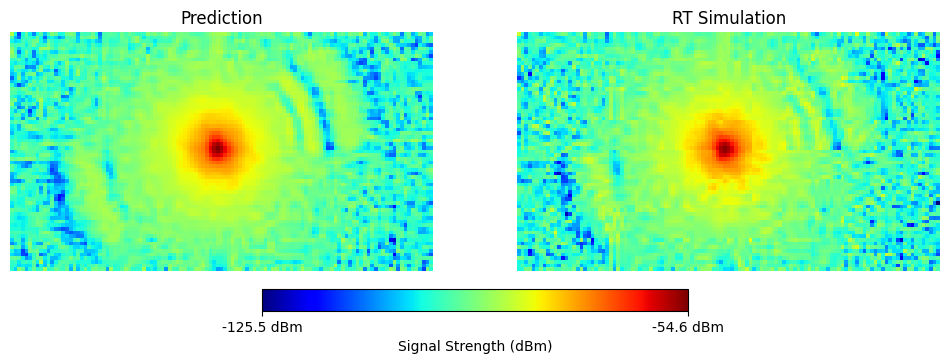

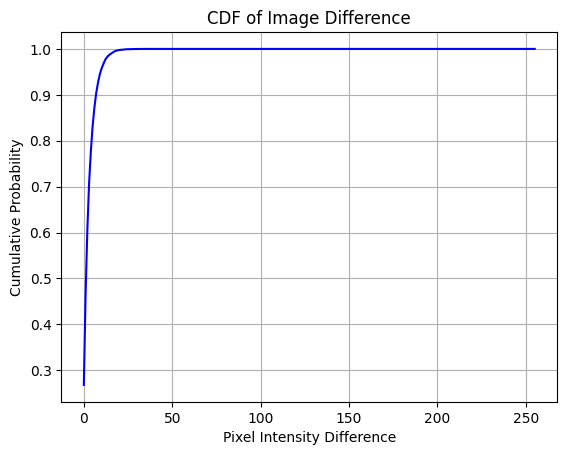

RMSE of Training Sample: 4.8405766


In [ ]:
#####################################################
# Plot the test sample, which are the final results
#####################################################
# Calculating Overall Testing Error
# First, obtain predictions for the testing set
predictions_2nd_leg = model_2nd_leg.predict(input_sample_test)
# Ensure that predictions and Y_test are reshaped or flattened if they are multi-dimensional, to compute RMSE correctly
predictions_2nd_leg = predictions_2nd_leg.flatten()
actuals = Y_test.flatten()
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actuals, predictions_2nd_leg)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Overall Testing Error (RMSE):", rmse)
# Compute MAE
mae = np.mean(np.abs(actuals - predictions_2nd_leg))
print("Overall Training Error (MAE):", mae)

i=2
# Extract the first sample
first_sample_test = input_sample_test[i]
# Expand dimensions to simulate a batch of size 1
first_sample_test = np.expand_dims(first_sample_test, axis=0)  # first_sample.shape = (1, 256, 256, 3)
print(first_sample_test.shape )
# Predict
prediction_test = model_2nd_leg.predict(first_sample_test)

# Resize the coverage map to its original size
prediction_test_resized = zoom(prediction_test.squeeze(), (65/prediction_test.shape[1], 115/prediction_test.shape[2]))
Y_test_resized = zoom(Y_test[i].squeeze(), (65/Y_test[i].shape[0], 115/Y_test[i].shape[1]))

# Define the color map
cmap = plt.cm.jet

# Determine the range of your data for consistent color mapping
combined = np.concatenate((prediction_test_resized.flatten(), Y_test_resized.flatten()))
min_val = combined.min()
max_val = combined.max()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the prediction heatmap
cax1 = axes[0].imshow(prediction_test_resized, interpolation='nearest', cmap=cmap, vmin=min_val, vmax=max_val)
axes[0].set_title("Prediction")
axes[0].axis('off')

# Display the ground truth heatmap
cax2 = axes[1].imshow(Y_test_resized, interpolation='nearest', cmap=cmap, vmin=min_val, vmax=max_val)
axes[1].set_title('RT Simulation')
axes[1].axis('off')

# Add colorbar, make sure to specify the ticks you want to display
# and their corresponding labels
colorbar = fig.colorbar(cax2, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.046, pad=0.04)
colorbar.set_label('Signal Strength (dBm)')
colorbar.set_ticks([min_val, max_val])
colorbar.set_ticklabels(['-125.5 dBm', '-54.6 dBm'])

plt.show()

# Numberical results including RMSE and CDF plot
squared_differences_train = (prediction_test.squeeze()- Y_test[i])**2
rmse_train = np.sqrt(squared_differences_train.mean())

difference = np.abs(prediction_test.squeeze()- Y_test[i])
flattened_diff = difference.flatten()

# Calculate the CDF
hist, bin_edges = np.histogram(flattened_diff, bins=256, range=(0, 256), density=True)
cdf = np.cumsum(hist) * np.diff(bin_edges)
# Plot the CDF
plt.plot(cdf, color='blue')
plt.title('CDF of Image Difference')
plt.xlabel('Pixel Intensity Difference')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()
print("RMSE of Training Sample:", rmse_train)

